In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
url = "https://raw.githubusercontent.com/entekang/6-FinalProject/master/data.xlsx"
df = pd.read_excel(url)

Processing for prediction of HTN

In [ ]:
df['Patient_ID'].nunique()

8602

In [ ]:
htn_change = df.groupby('Patient_ID')['HTN'].mean().reset_index()
htn_change['HTN'].unique()   # see that HTN status does not change for individuals

array([1., 0.])

In [ ]:
cts_per_patient = df.groupby('Patient_ID').size().reset_index()
cts_per_patient.columns = ['Patient_ID', 'n']
cts_per_patient

,Patient_ID,n
0,1001000000000054,1
1,1001000000001950,1
2,1001000000003945,1
3,1001000000004538,1
4,1001000000005143,1
...,...,...
8597,10001000000003708,2
8598,10001000000003812,1
8599,10001000000003816,1
8600,10001000000003852,1


In [ ]:
cts_per_patient.max()

Patient_ID    10001000000003892
n                             8
dtype: int64

In [ ]:
unque = cts_per_patient[(cts_per_patient.n == 1)]
dup = cts_per_patient[(cts_per_patient.n > 1)]
print(unque.shape)
print(dup.shape)

(7503, 2)
(1099, 2)


In [ ]:
# obtain last measurement for observations with repeats
dup_df = df[df['Patient_ID'].isin(dup['Patient_ID'])].groupby('Patient_ID').nth(-1)

In [ ]:
un_df = df[df['Patient_ID'].isin(unque['Patient_ID'])]
un_df.shape

(7503, 43)

In [ ]:
# combine them together
df2 = pd.concat([un_df, dup_df])
df2.shape

(8602, 43)

In [ ]:
df2.isna().sum()

Age_at_Exam                                   0
sBP                                           4
sBP_Date                                      0
BMI                                           0
BMI_Date                                      0
LDL                                          51
LDL_Date                                      0
HDL                                          68
HDL_Date                                     61
A1c                                           0
A1c_Date                                      0
TG                                           51
TG_Date                                      41
FBS                                           0
FBS_Date                                      0
FBS>DM                                        0
Total_Cholesterol                           192
Total_Cholesterol_Lab_Date                  183
Diabetes                                      0
DM_OnsetDate                               4462
Depression                              

In [ ]:
df2.groupby('HTN').size()

HTN
0    3291
1    5311
dtype: int64

In [ ]:
df2.groupby('Diabetes').size()

Diabetes
0    4460
1    4142
dtype: int64

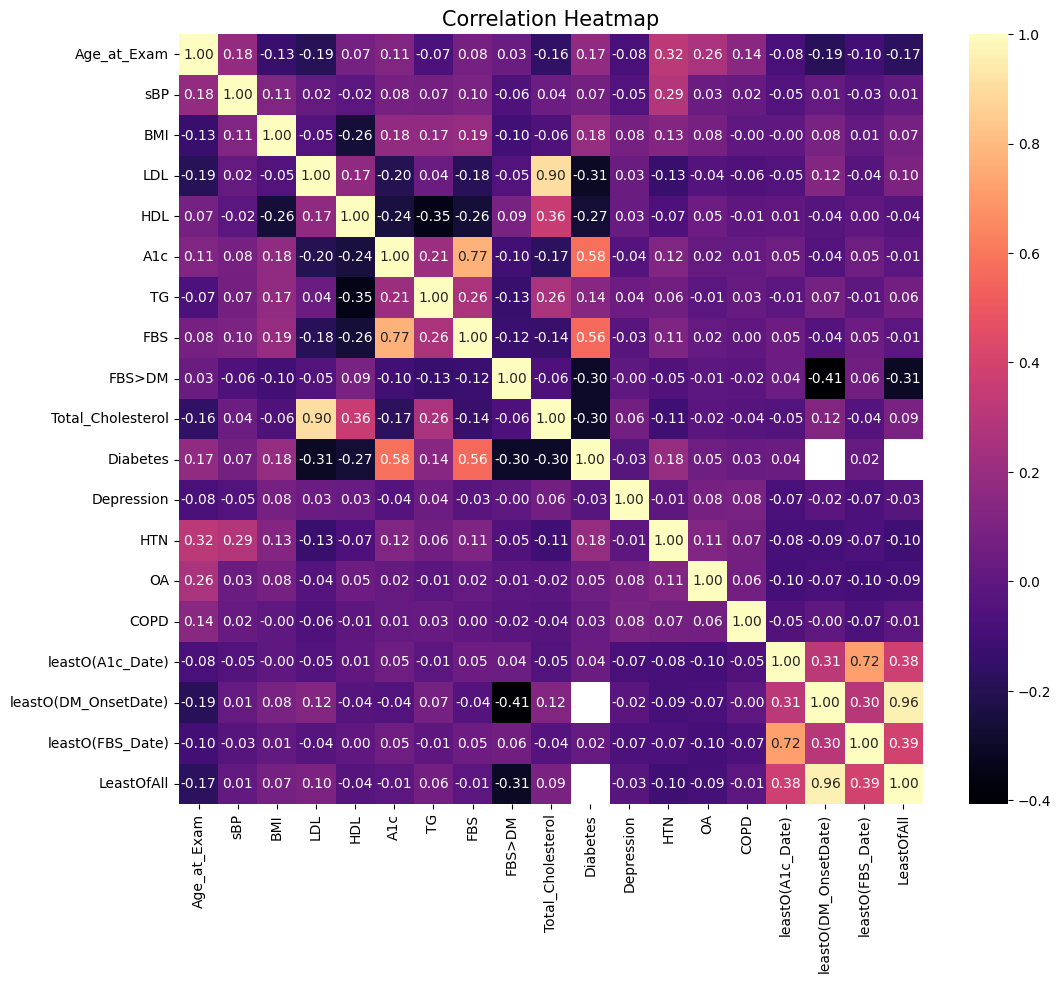

In [ ]:
numerical_features = [
  col for col in df2.select_dtypes(include=[np.number]).columns
  if not col.endswith('_ID')
]

correlation_matrix = df2[numerical_features].corr()

# Plot the updated correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

In [ ]:
X = df2[['Age_at_Exam', 'BMI', 'Sex', 'sBP', 'Diabetes']]   # clinically important variables, don't want ones that are highly correlated
y = df2['HTN']

In [ ]:
X['Sex'].unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
X = pd.get_dummies(X, drop_first = True)

In [ ]:
X.isna().sum() # four missing values of sBP

Age_at_Exam    0
BMI            0
sBP            4
Diabetes       0
Sex_Male       0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)
print(X_train.shape)
print(y_train.shape)

(6021, 5)
(6021,)


In [ ]:
X_train.isna().sum()

Age_at_Exam    0
BMI            0
sBP            1
Diabetes       0
Sex_Male       0
dtype: int64

In [ ]:
imp = SimpleImputer(strategy='most_frequent')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train))
X_test_imp= pd.DataFrame(imp.transform(X_test))

X_train_imp.columns = X_train.columns
X_test_imp.columns = X_test.columns

In [ ]:
X_train_imp.head()

,Age_at_Exam,BMI,sBP,Diabetes,Sex_Male
0,84.0,35.26,130.0,1.0,1.0
1,61.0,31.60,130.0,1.0,0.0
2,55.0,33.82,115.0,0.0,1.0
3,58.0,26.60,124.0,0.0,1.0
4,71.0,49.80,130.0,1.0,0.0


In [ ]:
y_train.head()

5663                1
5588                1
1984                1
3062                0
1002000000009059    1
Name: HTN, dtype: int64

In [ ]:
log_reg = LogisticRegression()
k_folds = KFold(n_splits = 5)

s = cross_val_score(log_reg, X_train_imp, y_train, cv = k_folds)

print("Cross Validation Scores: ", s)
print("Average CV Score: ", s.mean())

Cross Validation Scores:  [0.73195021 0.71262458 0.70182724 0.72425249 0.69767442]
Average CV Score:  0.7136657890020816


In [ ]:
import statsmodels.api as sm

# Add a constant term for the intercept
Xt = sm.add_constant(X_train_imp)

# Create and fit logistic regression model
log_regr = sm.Logit(list(y_train), Xt).fit()

# Get summary report
summary = log_regr.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.565936
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6021
Model:                          Logit   Df Residuals:                     6015
Method:                           MLE   Df Model:                            5
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                  0.1506
Time:                        21:25:50   Log-Likelihood:                -3407.5
converged:                       True   LL-Null:                       -4011.8
Covariance Type:            nonrobust   LLR p-value:                4.148e-259
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.5903      0.329    -26.102      0.000      -9.235      -7.945
Age_at_Exam     0.0506    

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_imp, y_train)

y_pred = log_reg.predict(X_test_imp)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[ 501  474]
 [ 247 1359]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58       975
           1       0.74      0.85      0.79      1606

    accuracy                           0.72      2581
   macro avg       0.71      0.68      0.69      2581
weighted avg       0.71      0.72      0.71      2581



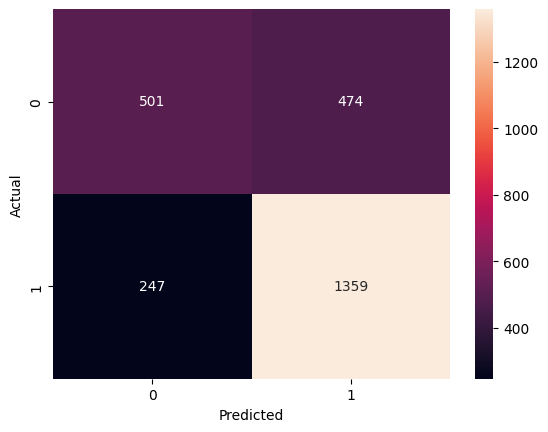

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Studies have shown that systolic blood pressure (sBP) is the best way to predict future cardiovascular events. Know that Hypertension (HTN) is defined as sBP > 130-139 and dBP > 80-89.
# In the absence of diastolic blood pressure readings, let us see what covariates can help us explain sBP readings.

In [ ]:
six_obs = cts_per_patient[(cts_per_patient.n == 6)]  # those with 6 obs.

In [ ]:
six_df = df[df['Patient_ID'].isin(six_obs['Patient_ID'])]

See that patients have a different baseline sBP measurement, and the effect of aging is different on each person. Some individual's sBP goes down as age increases, while others go up.

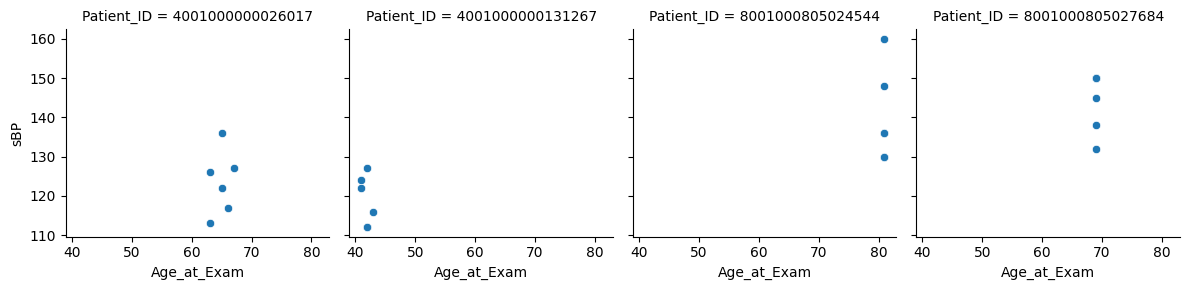

In [ ]:
g= sns.FacetGrid(six_df, col='Patient_ID')
g.map(sns.scatterplot, "Age_at_Exam", "sBP")

In [ ]:
six_df[six_df['Patient_ID'] == 4001000000026017]

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
9476,65,122.0,2013-04-11,32.045160,2013-04-11,1.39,2012-11-14,0.85,2012-11-14,6.6,...,41227.0,39254.0,41920.0,39254.0,False,False,4001000000026017,2007-06-14,2006-06-14,Yes
9477,67,127.0,2015-01-12,31.070000,2015-01-12,1.33,2014-11-10,0.84,2014-11-10,6.7,...,41227.0,39254.0,41920.0,39254.0,False,False,4001000000026017,2007-06-14,2006-06-14,Yes
9483,63,126.0,2011-05-19,31.831305,2011-05-19,1.38,2011-11-05,0.95,2011-11-05,6.6,...,41227.0,39254.0,41920.0,39254.0,False,False,4001000000026017,2007-06-14,2006-06-14,Yes
9489,66,117.0,2014-01-17,32.450000,2013-12-03,1.50,2013-11-27,0.96,2013-11-27,6.9,...,41227.0,39254.0,41920.0,39254.0,False,False,4001000000026017,2007-06-14,2006-06-14,Yes
9497,63,113.0,2011-06-10,31.831305,2011-06-10,1.38,2011-11-05,0.95,2011-11-05,6.6,...,41227.0,39254.0,41920.0,39254.0,False,False,4001000000026017,2007-06-14,2006-06-14,Yes
9498,65,136.0,2013-12-03,32.450000,2013-12-03,1.50,2013-11-27,0.96,2013-11-27,6.9,...,41227.0,39254.0,41920.0,39254.0,False,False,4001000000026017,2007-06-14,2006-06-14,Yes


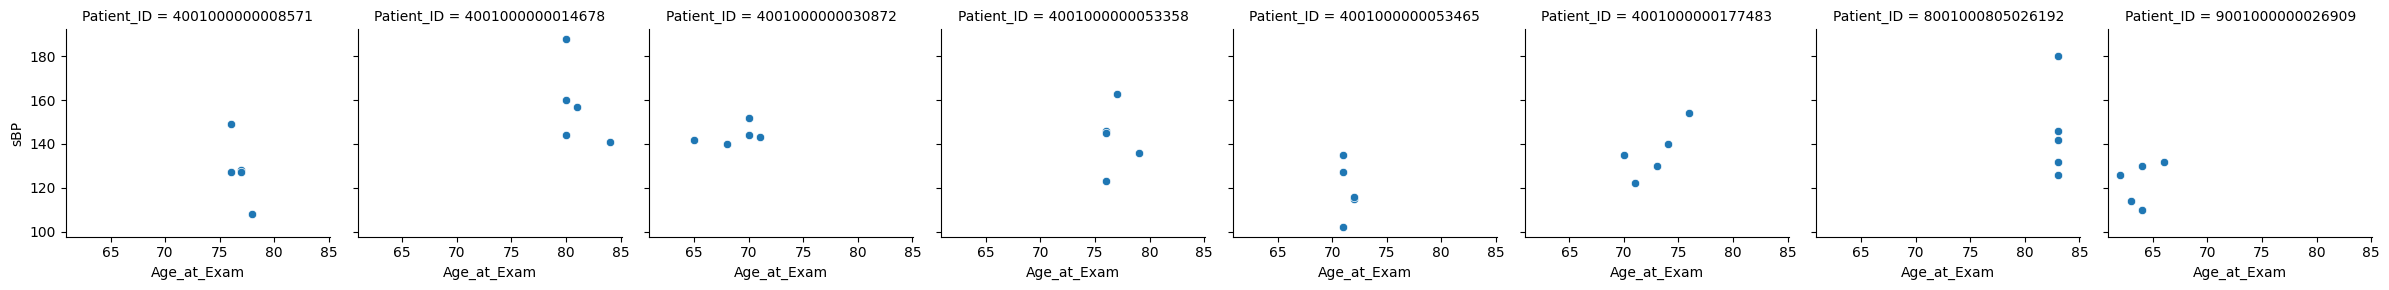

In [ ]:
five_obs = cts_per_patient[(cts_per_patient.n == 5)]  # those with 5 obs.
five_df = df[df['Patient_ID'].isin(five_obs['Patient_ID'])]
g2= sns.FacetGrid(five_df, col='Patient_ID')
g2.map(sns.scatterplot, "Age_at_Exam", "sBP")

In [ ]:
five_df[five_df['Patient_ID'] == 4001000000014678]

**We will look at this through GEEs (Generalized Estimating Equations)**

In [ ]:
# drop missing values of sBP (our response variable)
df.isna().sum()

Age_at_Exam                                   0
sBP                                           4
sBP_Date                                      0
BMI                                           0
BMI_Date                                      0
LDL                                          61
LDL_Date                                      0
HDL                                          72
HDL_Date                                     64
A1c                                           0
A1c_Date                                      0
TG                                           53
TG_Date                                      42
FBS                                           0
FBS_Date                                      0
FBS>DM                                        0
Total_Cholesterol                           207
Total_Cholesterol_Lab_Date                  197
Diabetes                                      0
DM_OnsetDate                               4863
Depression                              

In [ ]:
df3 = df.dropna(subset = 'sBP')
df3.shape

(9996, 43)

In [ ]:
fam = sm.families.Gaussian()

ind = sm.cov_struct.Exchangeable()

mod = smf.gee("sBP~ Age_at_Exam+DIABETES+Sex+BMI", "Patient_ID", df3,
             cov_struct=ind, family=fam)

res = mod.fit()

print(res.summary())

                               GEE Regression Results                              
Dep. Variable:                         sBP   No. Observations:                 9996
Model:                                 GEE   No. clusters:                     8598
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   8
Family:                           Gaussian   Mean cluster size:                 1.2
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Fri, 01 Dec 2023   Scale:                         275.249
Covariance type:                    robust   Time:                         01:07:49
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         103.9048      1.259     82.524      0.000     101.437     

**Linear Mixed Effects Model**

Random intercept

In [ ]:
md = smf.mixedlm("sBP ~ Age_at_Exam+DIABETES+Sex+BMI", df3, groups=df3["Patient_ID"])

mdf = md.fit()

In [ ]:
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  sBP        
No. Observations:   9996     Method:              REML       
No. Groups:         8598     Scale:               170.1392   
Min. group size:    1        Log-Likelihood:      -42133.9600
Max. group size:    8        Converged:           Yes        
Mean group size:    1.2                                      
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       103.879    1.238 83.910 0.000 101.453 106.305
DIABETES[T.Yes]   0.215    0.361  0.596 0.551  -0.492   0.922
Sex[T.Male]       0.836    0.349  2.396 0.017   0.152   1.520
Age_at_Exam       0.248    0.013 18.365 0.000   0.221   0.274
BMI               0.338    0.026 13.103 0.000   0.288   0.389
Group Var       104.687    0.720                             



In [ ]:
re = mdf.random_effects

# Multiply each BLUP by the random effects design matrix for one group
rex = [np.dot(md.exog_re_li[j], re[k]) for (j, k) in enumerate(md.group_labels)]

# Add the fixed and random terms to get the overall prediction
rex = np.concatenate(rex)
yp = mdf.fittedvalues + rex

In [ ]:
yp.head()

0    129.612735
1    144.494014
2    132.561270
3    129.320163
4    121.450289
dtype: float64

In [ ]:
df3['sBP'].head()

0    126.0
1    135.0
2    133.0
3    136.0
4    123.0
Name: sBP, dtype: float64

Train-test splitting

In [ ]:
# Grouping by 'patient_nbr' and creating a list of dataframes, one per group
grouped = df3.groupby('Patient_ID')
grouped_dfs = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_dfs, test_size=0.2, random_state=16)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(7964, 43)
(2032, 43)


In [ ]:
train_df.head()

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
3039,47,120.0,2015-06-09,19.00,2015-06-09,2.19,2015-06-29,1.97,2015-06-29,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,1002000000194197,NaT,NaT,No
3748,53,124.0,2011-11-02,26.50,2011-11-02,2.87,2011-09-09,1.60,2011-09-09,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2001000000029791,NaT,NaT,No
5684,64,130.0,2012-03-19,28.50,2011-12-19,1.94,2012-04-27,1.52,2012-04-27,6.0,...,41227.0,40855.0,41227.0,40855.0,False,False,9001000000022311,2011-11-01,2010-11-01,Yes
2050,83,103.0,2009-11-30,30.29,2009-11-30,1.88,2009-12-12,0.89,2009-12-12,6.3,...,41402.0,NaN,41402.0,NaN,NaN,NaN,4001000000203671,NaT,NaT,No
3426,37,139.0,2014-08-06,27.10,2014-06-13,2.57,2014-09-16,1.32,2014-09-16,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,1003000000162340,NaT,NaT,No


In [ ]:
1002000000194197 in train_df['Patient_ID']   # make sure the splitting was done by patient id

False

In [ ]:
X_train_lmm = train_df[['Age_at_Exam', 'BMI', 'Sex', 'Diabetes', 'Patient_ID', 'sBP']]
X_test_lmm = test_df[['Age_at_Exam', 'BMI', 'Sex', 'Diabetes']]

(7964, 6)
(7964,)


In [ ]:
m1 = smf.mixedlm("sBP ~ Age_at_Exam+Diabetes+Sex+BMI", X_train_lmm, groups=X_train_lmm["Patient_ID"])
m1fit = m1.fit()
print(m1fit.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sBP        
No. Observations: 7964    Method:             REML       
No. Groups:       6878    Scale:              164.5815   
Min. group size:  1       Log-Likelihood:     -33543.3177
Max. group size:  8       Converged:          Yes        
Mean group size:  1.2                                    
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   104.372    1.391 75.011 0.000 101.645 107.099
Sex[T.Male]   0.763    0.390  1.956 0.051  -0.002   1.528
Age_at_Exam   0.249    0.015 16.587 0.000   0.220   0.279
Diabetes      0.271    0.403  0.673 0.501  -0.519   1.062
BMI           0.315    0.029 10.899 0.000   0.259   0.372
Group Var   108.878    0.835                             



In [ ]:
m1fit.predict(X_test_lmm) # test predictions

2099    136.361246
3568    132.711943
7096    132.791109
7572    141.121488
4437    123.273922
           ...    
1492    132.469907
6626    126.568746
7383    131.906320
5349    128.120808
8223    131.234398
Length: 2032, dtype: float64

In [ ]:
test_df['sBP']   # actual values

2099    127.0
3568    130.0
7096    151.0
7572    136.0
4437    110.0
        ...  
1492    130.0
6626    130.0
7383    142.0
5349    117.0
8223    128.0
Name: sBP, Length: 2032, dtype: float64

In [ ]:
mse = mean_squared_error(test_df['sBP'] , m1fit.predict(X_test_lmm))
r2 = r2_score(test_df['sBP'] , m1fit.predict(X_test_lmm))

In [ ]:
print(mse)
print(r2)

280.9385876363848
0.054186383478910694


Random intercept and slope

In [ ]:
md2 = smf.mixedlm("sBP ~ Age_at_Exam+DIABETES+Sex+BMI", df3, groups=df3["Patient_ID"], re_formula="~Age_at_Exam")
mdf2 = md2.fit()
print(mdf2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     sBP        
No. Observations:     9996        Method:                 REML       
No. Groups:           8598        Scale:                  169.8298   
Min. group size:      1           Log-Likelihood:         -42119.6590
Max. group size:      8           Converged:              Yes        
Mean group size:      1.2                                            
---------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept               103.483    1.235 83.766 0.000 101.062 105.905
DIABETES[T.Yes]           0.205    0.360  0.569 0.569  -0.501   0.911
Sex[T.Male]               1.024    0.351  2.918 0.004   0.336   1.711
Age_at_Exam               0.250    0.014 18.316 0.000   0.223   0.276
BMI                       0.345    0

# NLP

In [9]:
import re

In [2]:
url = "https://raw.githubusercontent.com/entekang/6-FinalProject/master/papers.xlsx"
paper = pd.read_excel(url)

In [5]:
paper.head()
paper.columns = ['none', 'text']

In [7]:
paper.drop('none', axis=1, inplace=True)
paper.head()

,text
0,Hypertension Is Predicted by Both Large and Sm...
1,Predicting hypertension among Korean cancer su...
2,Development and validation of a novel diagnost...
3,Epidemiology of Hypertension in the Elderly. I...
4,Does B-Type Natriuretic Peptide Predict the Ne...


In [10]:
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text)

paper['text'] = paper['text'].apply(remove_special_characters)

In [12]:
paper['text'] = paper['text'].str.lower()

In [13]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
def tokenize_text(text):
   return word_tokenize(text)
paper['text'] = paper['text'].apply(tokenize_text)
paper.head()

,text
0,"[hypertension, is, predicted, by, both, large,..."
1,"[predicting, hypertension, among, korean, canc..."
2,"[development, and, validation, of, a, novel, d..."
3,"[epidemiology, of, hypertension, in, the, elde..."
4,"[does, btype, natriuretic, peptide, predict, t..."


In [15]:
from nltk.corpus import stopwords

# Download the set of stopwords from NLTK. This is necessary the first time you run this code.
nltk.download('stopwords')

# Define a function that removes stop words from a list of tokens.
# Stop words are common words that are usually filtered out in NLP tasks.
def remove_stop_words(tokens):
    # Create a set of English stop words. Sets are faster for membership tests than lists.
    stop_words_set = set(stopwords.words('english'))

    # Return a new list that contains only the tokens that are not stop words.
    # The token is also converted to lowercase to ensure case-insensitive matching.
    return [token for token in tokens if token.lower() not in stop_words_set]
paper['text'] = paper['text'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
context_sensitive_stop_words = set(['blood pressure', 'sBP', 'hypertension', 'high blood pressure', 'study', 'patient', 'subject', 'model', 'may', 'patients', 'data', 'et al', 'studies', 'use', 'used','et   al'])

# English stop words
stop_words_set = set(stopwords.words('english'))

# Extend the previously defined function to remove both general and context-sensitive stop words
def remove_context_sensitive_stop_words(tokens):
    # Combine the general English stop words with the context-specific stop words
    # to create a comprehensive set of words to filter out.
    all_stop_words = stop_words_set | context_sensitive_stop_words
    return [token for token in tokens if token.lower() not in all_stop_words]

# Apply the updated function to remove both general and context-sensitive stop words
paper['text'] = paper['text'].apply(remove_context_sensitive_stop_words)

In [17]:
paper.head()

,text
0,"[predicted, large, small, artery, disease, sma..."
1,"[predicting, among, korean, cancer, survivors,..."
2,"[development, validation, novel, diagnostic, n..."
3,"[epidemiology, elderly, western, populations, ..."
4,"[btype, natriuretic, peptide, predict, new, on..."


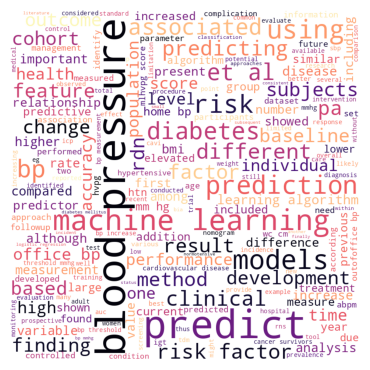

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Combine all tokens from the 'tokens_no_stop_context' column into a single list
# Remove .head(5000) to generate the word cloud for the entire dataset
all_tokens = sum(paper['text'].head(5000).tolist(), [])

# Create a text string required by WordCloud
text = ' '.join(all_tokens)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      colormap='magma',  # Use the 'magma' colormap
                      min_font_size = 10).generate(text)

# Plot the WordCloud image
plt.figure(figsize = (3.5, 3.5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()